# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [2]:
data.shape

(13150, 10)

In [3]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [5]:
max_depth = None
num_pct = 10
max_features = None
min_gain=0.001

In [6]:
j = 1
print(X.columns[j])
splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / num_pct).tolist())
splits = np.unique(splits)
splits

Mileage


array([5.00000e+00, 1.58728e+04, 2.32508e+04, 2.98747e+04, 3.56432e+04,
       4.16580e+04, 4.83404e+04, 6.16152e+04, 8.07292e+04, 1.06371e+05])

In [7]:
k = 5
filter_l = X.iloc[:, j] < splits[k]

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [8]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

gini_l = gini(y_l)
print(gini_l)

gini_r = gini(y_r)
print(gini_r)

0.20562506325087826
0.3991431537249346


In [9]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [10]:
gini_impurity(X.iloc[:, j], y, splits[k])

0.18496148274516044

In [11]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [12]:
j, split, gain = best_split(X_train, y_train, 5)
j, split, gain

(1, 56598.66666666667, 0.23507164147905313)

In [13]:
filter_l = X.iloc[:, j] < split

y_l = y.loc[filter_l]
y_r = y.loc[~filter_l]

In [14]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [15]:
tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=1, num_pct=10)


{'y_pred': 1,
 'y_prob': 0.5780753517930095,
 'level': 0,
 'split': [1, 52187.63636363637],
 'n_samples': 8810,
 'gain': 0.23872134898880762,
 'sl': {'y_pred': 1,
  'y_prob': 0.8391583452211127,
  'level': 1,
  'split': -1,
  'n_samples': 5606,
  'gain': -1},
 'sr': {'y_pred': 0,
  'y_prob': 0.12133499688084841,
  'level': 1,
  'split': -1,
  'n_samples': 3204,
  'gain': -1}}

In [16]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [17]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]
        
        

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted    

In [18]:
y_pred = tree_predict(X_test, tree)

In [19]:
from sklearn import metrics
print('Accuracy ',metrics.accuracy_score(y_test, y_pred))

Accuracy  0.8610599078341014


# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set  ## Asumiendo majority voting

In [20]:
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
len(samples)

10

In [21]:
n_estimators = 10
np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

trees = {}
for i in range(10):
    trees[i] =tree_grow(X_train.iloc[samples[i]], y_train.iloc[samples[i]], max_depth=3)

In [22]:
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))

for i in range(n_estimators):
    y_pred_df.iloc[:, i] = tree_predict(X_test, trees[i])
    

In [23]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators/ 2)).astype(np.int)
print('Accuracy:',metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.8670506912442396


# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [24]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=None):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    if max_features is None:
        j, split, gain = best_split(X, y, num_pct)
    else:
        sample = np.random.choice(a=X.shape[1], size=max_features, replace=False)
        X_sample=X.iloc[:, sample]
        j, split, gain = best_split(X_sample, y, num_pct)
        j=sample[j]
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct,max_features=max_features)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct,max_features=max_features)
    
    return tree

In [25]:
tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=None)

In [26]:
y_pred=tree_predict(X_test, tree)
print('Accuracy:',metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.8433179723502304


In [27]:
feature_cols = data.columns.drop('HighPrice')
feature_cols

feature_range = range(1, len(feature_cols)+1)
accuracy_scores = []

In [28]:
for feature in feature_range:
    tree=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=None, num_pct=10, max_features=feature)
    y_pred=tree_predict(X_test, tree)
    print(feature, metrics.accuracy_score(y_pred, y_test))

1 0.5824884792626728
2 0.5824884792626728
3 0.867741935483871
4 0.8682027649769585
5 0.8640552995391705
6 0.8656682027649769
7 0.8663594470046083
8 0.8587557603686636
9 0.8428571428571429


Se observa que es mayor la precisión cuando las variables utilizadas son 3. 

# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set 

In [29]:
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]
len(samples)

10

In [30]:
n_estimators=10
y_pred_df = pd.DataFrame(index=y_test.index, columns=[list(range(n_estimators))])
trees = {}

for i in range(10):
    trees[i] = tree_grow(X_train.iloc[samples[i]], y_train.iloc[samples[i]], level=0, min_gain=0.001, max_depth=None, num_pct=10,max_features=int(np.log(X.shape[1])))
    y_pred_df.iloc[:, i] = tree_predict(X_test, trees[i])

In [31]:
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)
print("F1-score:",metrics.f1_score(y_pred, y_test))
print("Accuracy:",metrics.accuracy_score(y_pred, y_test))

F1-score: 0.8886474741988051
Accuracy: 0.8582949308755761


# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

C:\Users\krist\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [33]:
from sklearn import metrics
clf = RandomForestClassifier()
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [34]:
y_pred = clf.predict(X_test)
print('Accuracy:',metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.8403225806451613


# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [35]:
max_depth_range = range(1, 21)
accuracy_scores = []

for depth in max_depth_range:
    clf = RandomForestClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

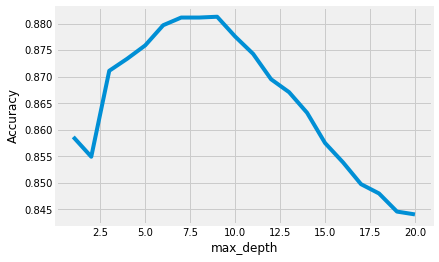

In [36]:
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [37]:
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.881293109097012, 9)

### Max_features

In [38]:
feature_cols = data.columns.drop('HighPrice')
feature_cols

Index(['Year', 'Mileage', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL',
       'M_CamryLE', 'M_CamrySE', 'M_CamryXLE'],
      dtype='object')

In [39]:
feature_range = range(1, len(feature_cols)+1)
accuracy_scores = []

for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=300, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

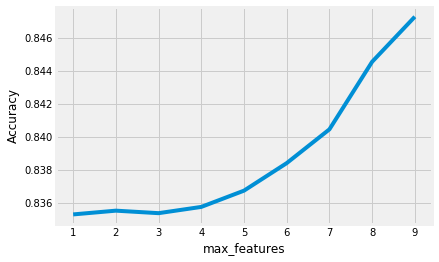

In [40]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [41]:
sorted(zip(accuracy_scores, feature_range))[::-1][0]

(0.8472993303499848, 9)

### n_estimators

In [42]:
estimator_range = range(10, 300, 10)
accuracy_scores = []
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

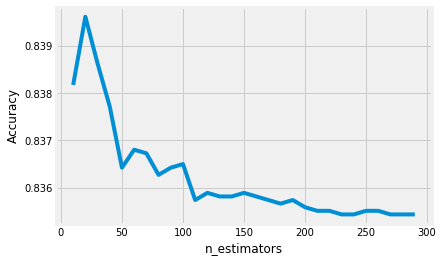

In [43]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [44]:
sorted(zip(accuracy_scores, estimator_range))[::-1][0]

(0.8396183455552627, 20)

In [45]:
clf = RandomForestClassifier(n_estimators=20, max_features=9, max_depth=9, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [46]:
y_pred = clf.predict(X_test)
print('Accuracy:',metrics.accuracy_score(y_pred, y_test))

Accuracy: 0.8758064516129033
